# Inference with Meta-Learners

## Import Libraries

In [1]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy.stats
from scipy.special import expit

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

## Data Generation

In [2]:
n = 500

In [3]:
x = np.random.uniform(low=-1, high=1, size=n)

let the DGP of $Z$ be defined as follows:

$Z_{i} = \phi (a_{i})$

where $\phi (x) = \frac{1}{1+e^{-x}}$

and $a_{i}=-5x_{i}+u_{i}$

In [4]:
def dgp_Z(x, n):
    
    u = np.random.randn(n) * 5
    a = (-5.0 * x) + u
    z = expit(a)

    Z = np.array([])
    for i in range(n):
        Z_i = np.random.choice(2, size=1, p=[1-z[i], z[i]])[0]
        Z = np.append(Z, Z_i)
    
    return Z

In [5]:
Z = dgp_Z(x, n)

let the DGP of $Y$ be defined as follows:

$Y_{i}=2x_{i}+\beta_{z} Z-2+u_{i}$

where $\beta_{z} = t(x)$

In [6]:
def dgp_Y(x, t_of_x, Z, n):
    
    u = np.random.randn(n) * 0.1
    Y = (2 * x) + (t_of_x(x) * Z) - 2 + u
    
    return Y

In [7]:
def beta_func(x):
    """Non-linearly defined treatment effects"""
    if x < 0:
        return 1.0
    elif x >= 0 and x < 0.5:
        return 2.0
    elif x >= 0.5:
        return 3.0

In [8]:
beta_func = np.vectorize(pyfunc=beta_func)

In [9]:
Y = dgp_Y(x, beta_func, Z, n)

In [10]:
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': beta_func(x),
                   'Y': Y,
                   })

In [11]:
df

,x,Z,t,Y
0,0.080045,0.0,2.0,-1.992925
1,0.786378,0.0,3.0,-0.640156
2,-0.666460,0.0,1.0,-3.406782
3,-0.840737,1.0,1.0,-2.667141
4,0.658172,0.0,3.0,-0.698874
...,...,...,...,...
495,0.021317,0.0,2.0,-1.903855
496,0.864957,0.0,3.0,-0.354134
497,0.808363,0.0,3.0,-0.280480
498,0.484167,0.0,2.0,-1.079312


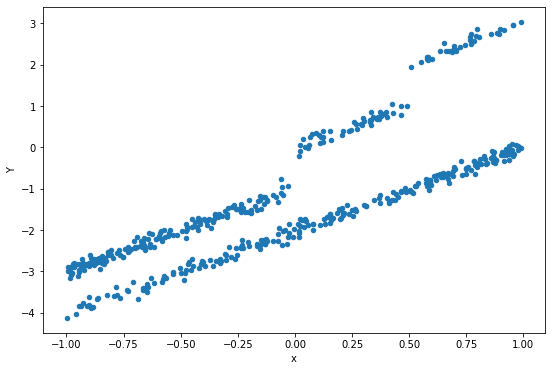

In [12]:
df.plot.scatter('x', 'Y', figsize=(9,6))

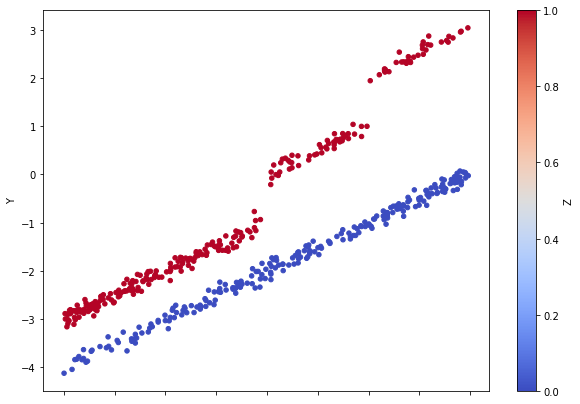

In [13]:
df.plot.scatter('x', 'Y', c='Z', cmap='coolwarm', figsize=(9+1,6+1))

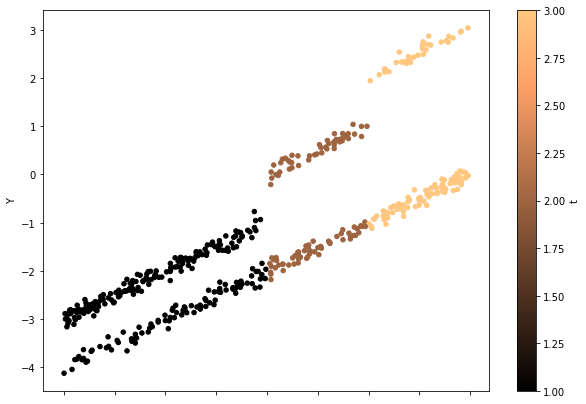

In [14]:
df.plot.scatter('x', 'Y', c='t', cmap='copper', figsize=(9+1,6+1))

## Mere Comparison of Means (Bad)

In [15]:
df.groupby('Z').mean()

,x,t,Y
Z,,,
0.0,0.159005,1.959514,-1.689634
1.0,-0.247994,1.462451,-1.031985


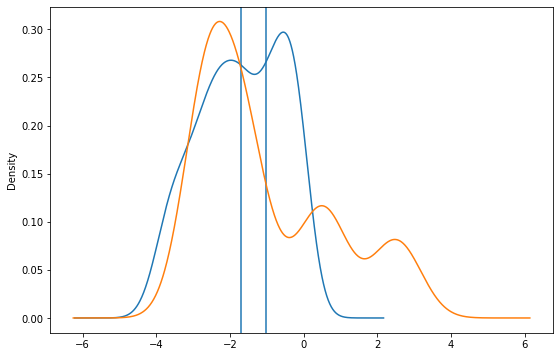

In [16]:
for _z in df.Z.unique():
    _df = df[df.Z == _z].Y
    plt.axvline(x=_df.mean())
    _df.plot.kde(figsize=(9,6))

In [17]:
df[df.Z == 1].Y.mean() - df[df.Z == 0].Y.mean()

0.6576491821287924

The above comparison, obviously, would not be indicative of the defined treatment effects.

## (1) w/ OLS (Unrealistic since $t(x)$ should be unknown)

In [18]:
data = sm.add_constant(df)

In [19]:
t_dummies = pd.get_dummies(beta_func(data['x'])).add_prefix('t_dummy_')

In [20]:
t_dummies

,t_dummy_1.0,t_dummy_2.0,t_dummy_3.0
0,0,1,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
495,0,1,0
496,0,0,1
497,0,0,1
498,0,1,0


In [21]:
data = pd.concat([data, t_dummies], axis=1)

In [22]:
new_cols = []

for _t_dummy in [_ for _ in data.columns if 't_dummy' in _]:
    _col_name = f'{_t_dummy}_multiply_Z'
    
    data[_col_name] = data[_t_dummy] * data['Z']
    new_cols.append(_col_name)

In [23]:
endog = data['Y']
# exog = data[['x', 'Z', 'const'] + t_dummies.columns.tolist()[1:]]
exog = data[['x', 'Z', 'const'] + new_cols[1:]]

In [24]:
model = sm.OLS(endog=endog, exog=exog)
result = model.fit()

In [25]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 3.062e+04
Date:                Wed, 03 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:58:48   Log-Likelihood:                 451.58
No. Observations:                 500   AIC:                            -893.2
Df Residuals:                     495   BIC:                            -872.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
x                          2

i.e. $\hat{y}=2.0089x+1.0119Z+0.9934(Dummy_{t=2.0}Z)+2.0165(Dummy_{t=3.0}Z)-2.0091$

where $Dummy_{t=1.0}$ would be utilized as the "base" category.

## (2) w/ Meta-Learners: T-Learner

In [26]:
params = {'max_depth': 5}

A "counter-factual" approach. Algorithm of selection is a Random Forest Regressor.

In [27]:
Z_is_0 = df.Z == 0
model_untreated = RandomForestRegressor(**params)
model_untreated.fit(
    X=df[Z_is_0][['x']],
    y=df[Z_is_0][['Y']]
)

C:\Users\ome3\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(max_depth=5)

In [28]:
yhat_0 = model_untreated.predict(df[['x']])

In [29]:
Z_is_1 = df.Z == 1
model_treated = RandomForestRegressor(**params)
model_treated.fit(
    X=df[Z_is_1][['x']],
    y=df[Z_is_1][['Y']]
)

C:\Users\ome3\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(max_depth=5)

In [30]:
yhat_1 = model_treated.predict(df[['x']])

### Compute ATE

In [31]:
(yhat_1 - yhat_0).mean()

1.7186346200689802

Predicted treatment effects, visualized

In [32]:
def vizPredictedTreatment(_df, _tau_hat):
    pd.concat([
        _df['x'],
        pd.Series(_tau_hat, name='t(x)'),
    ], axis=1).plot.scatter('x', 't(x)', label='Predicted t(x)', figsize=(9,6))

    plt.hlines(1.0, -1.0, 0.0, linestyle='dashed')
    plt.hlines(2.0, 0.0, 0.5, linestyle='dashed')
    plt.hlines(3.0, 0.5, 1.0, linestyle='dashed')
    
    ATE = (_tau_hat).mean()
    plt.hlines(ATE, -1.0, 1.0)

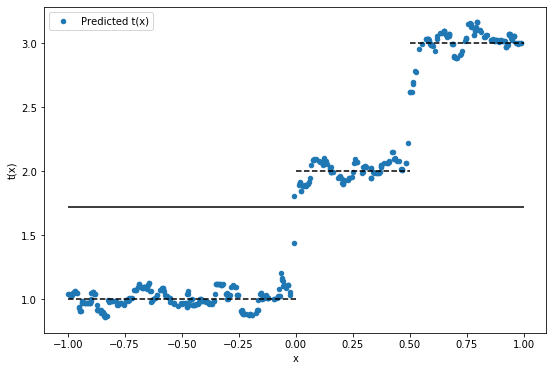

In [33]:
vizPredictedTreatment(df, yhat_1 - yhat_0)

### ATT

In [34]:
(df[Z_is_1]['Y'] - model_untreated.predict(df[Z_is_1][['x']])).mean()

1.4707884205828063

### ATU

In [35]:
(model_treated.predict(df[Z_is_0][['x']]) - df[Z_is_0]['Y']).mean()

1.9719603027859134

## (3) w/ Meta-Learners: S-Learner

In [36]:
model = RandomForestRegressor(**params)
model.fit(df[['x', 'Z']], df[['Y']])

C:\Users\ome3\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(max_depth=5)

In [37]:
yhat_0 = model.predict(df[['x', 'Z']].assign(Z=np.zeros(len(df))))
yhat_1 = model.predict(df[['x', 'Z']].assign(Z=np.ones(len(df))))

### ATE

In [38]:
ATE = (yhat_1 - yhat_0).mean()
ATE

1.7002704482318307

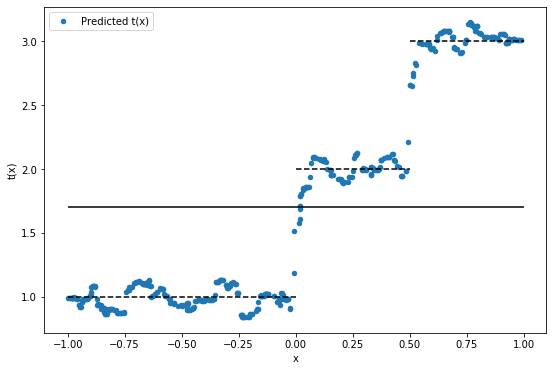

In [39]:
vizPredictedTreatment(df, yhat_1 - yhat_0)

## (4) w/ Meta-Learners: X-Learner

In [40]:
tau_0 = model_treated.predict(df[Z_is_0][['x']]) - df[Z_is_0]['Y']
tau_1 = df[Z_is_1]['Y'] - model_untreated.predict(df[Z_is_1][['x']])

In [41]:
model_ATT = RandomForestRegressor(**params)
model_ATT.fit(
    X=df[Z_is_0][['x']],
    y=tau_0,
)

RandomForestRegressor(max_depth=5)

In [42]:
model_ATU = RandomForestRegressor(**params)
model_ATU.fit(
    X=df[Z_is_1][['x']],
    y=tau_1,
)

RandomForestRegressor(max_depth=5)

### Compute Propensity Score

In [43]:
_ = LogisticRegression().fit(df[['x']], df['Z'])
p_score = _.predict_proba(df[['x']])

In [44]:
tau = p_score[:, 1] * model_ATT.predict(df[['x']]) + p_score[:, 0] * model_ATU.predict(df[['x']])

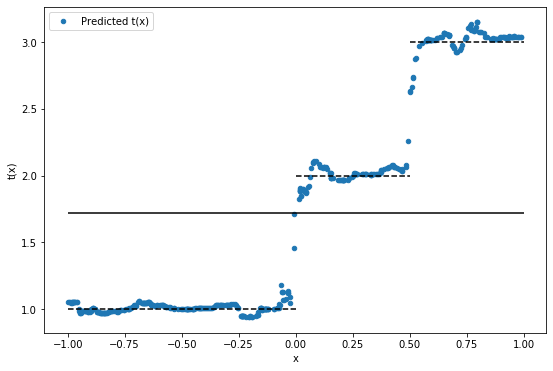

In [45]:
vizPredictedTreatment(df, tau)